In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from typing import Sequence
import os

import mechafil.data as mecha_data
from datetime import date, timedelta
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C

import cel_utils.disk_utils as du

from tqdm.auto import tqdm

In [3]:
from statsforecast.models import AutoARIMA
from statsforecast import StatsForecast

In [4]:
start_date = date(2021, 3, 15)
current_date = date.today() - timedelta(days=2)

In [5]:
auth_token_fp = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'
offline_data = 'offline'
os.makedirs(offline_data, exist_ok=True)

In [6]:
# setup data from starboard
mecha_data.setup_spacescope(auth_token_fp)
stats_df = mecha_data.spacescope_obj.query_spacescope_supply_stats(start_date, current_date)

In [7]:
# generate all data needed to run model
forecast_length = 1
end_date = current_date + timedelta(days=forecast_length)
    
offline_data = data.get_simulation_data(auth_token_fp, start_date, current_date, end_date)

In [8]:
# static inputs
forecast_length = 1
sector_duration = 360

# these are noops
rbp_val = 6
rr_val = 0.6
fpr_val = 0.6
rbp = jnp.ones(forecast_length) * rbp_val
rr = jnp.ones(forecast_length) * rr_val
fpr = jnp.ones(forecast_length) * fpr_val
lock_target=0.3

simulation_results = sim.run_sim(
    rbp,
    rr,
    fpr,
    lock_target,

    start_date,
    current_date,
    forecast_length,
    sector_duration,
    offline_data
)

In [9]:
# convert to a dataframe
df = pd.DataFrame({
    'unique_id': 'kpis',
    'ds': pd.date_range(start_date, end_date, freq='D')[:-1],
    'y': stats_df['locked_fil'].values / 1.0e6,
    'rbp': simulation_results['network_RBP_EIB'],
    'qap': simulation_results['network_QAP_EIB'],
    'baseline': simulation_results['network_baseline_EIB'],
    'cs': simulation_results['circ_supply'] / 1.0e6,
    'locked': simulation_results['network_locked'] / 1.0e6
})

In [10]:
models = [AutoARIMA(season_length = 7)]
sf = StatsForecast(
    models=models, 
    freq='D', 
    n_jobs=-1
)

In [32]:
forecasts = {}
level = [95]
train_sizes = [400, 500, 600]
# features_to_use = ['unique_id', 'ds', 'rbp','qap','baseline','cs','locked']
features_to_use = ['unique_id', 'ds', 'rbp','qap','baseline','cs','locked']

feature_groups = [
    ('Power', ['rbp', 'qap', 'baseline']),
    ('Supply', ['cs', 'locked']),
    ('Power+Supply', ['rbp', 'qap', 'baseline', 'cs', 'locked'])
]

for feature_group_name, feature_group in tqdm(feature_groups):
    features_to_use = ['unique_id', 'ds']  # must be in every input
    features_to_use.extend(feature_group)
    
    train_cols = ['y']
    train_cols.extend(features_to_use)
    for train_size in train_sizes:
        train_df = df.iloc[0:train_size][train_cols]
        
        X_test = df.iloc[train_size:][features_to_use]

        horizon = len(X_test)

        fcst = sf.forecast(df=train_df, h=horizon, X_df=X_test, level=level)
        fcst = fcst.reset_index()

        forecasts[(feature_group_name, train_size)] = fcst

  0%|          | 0/3 [00:00<?, ?it/s]

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


<IPython.core.display.Javascript object>


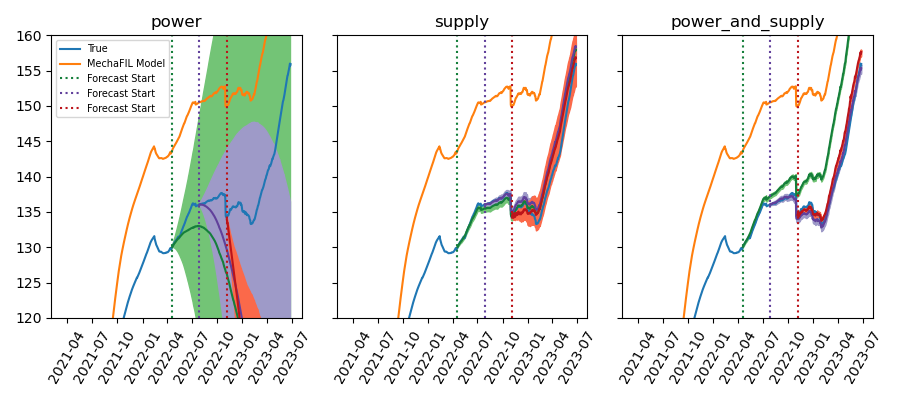

/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_57147/1741027302.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[jj].set_xticklabels(ax[jj].get_xticklabels(), rotation=60)


In [45]:
fig, ax = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=(9,4))

for jj, (feature_group_name, feature_group) in enumerate(feature_groups):
    ax[jj].plot(df['ds'], df['y'], label="True")
    ax[jj].plot(df['ds'], df['locked'], label='MechaFIL Model')

    colors = ['Greens', 'Purples', 'Reds', 'Greys']

    for ii, train_size in enumerate(train_sizes):
        fcst = forecasts[(feature_group_name,train_size)]

        c = mpl.colormaps[colors[ii]]

        ax[jj].axvline(fcst.iloc[0]['ds'], color=c(0.8), linestyle=':', label='Forecast Start')
        ax[jj].plot(fcst['ds'], fcst['AutoARIMA'], color=c(0.8))
        ax[jj].fill_between(fcst['ds'], fcst['AutoARIMA-lo-95'], fcst['AutoARIMA-hi-95'], color=c(0.5))
    ax[jj].set_xticklabels(ax[jj].get_xticklabels(), rotation=60)
    ax[jj].set_ylim(120,160)
    ax[jj].set_title(feature_group_name)
    if jj == 0:
        ax[jj].legend(fontsize=7)
    
plt.tight_layout()